In [1]:
import xarray as xr
import numpy as np
import numpy as np
import xarray as xr
import os
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

In [3]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import box
from cartopy.io.shapereader import natural_earth
from scipy.stats import shapiro, ttest_ind

# ─── SETTINGS ─────────────────────────────────────────────────────────
power_dir = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power"
era5_dir  = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power_Era5_h_1x1"
models    = [
    "ACCESS-CM2","CanESM5","CMCC-CM2-SR5","CMCC-ESM2",
    "HadGEM3-GC31-LL","HadGEM3-GC31-MM","MRI-ESM2-0"
]
# period codes
BOC_code  = "BOC"    # model “historical”
ERA5_code = "ERA5"   # your Era5 files

# ─── 0) Load country shapes & include TUR ─────────────────────────────
shp   = natural_earth('110m','cultural','admin_0_countries')
world = gpd.read_file(shp).set_crs("EPSG:4326")

# build a Europe+Turkey GeoDataFrame keyed by ISO3
eur = world[
    (world.CONTINENT == "Europe") | (world.ADM0_A3 == "TUR")
][["ADM0_A3","geometry"]].rename(columns={"ADM0_A3":"iso3"})

# ─── CONTAINER FOR RESULTS ────────────────────────────────────────────
all_results = []

for model in models:
    # 1) CSV paths
    boc_csv  = os.path.join(
        power_dir, f"{model}_1x1grid/historical/solar_drought_events_BOC.csv"
    )
    era5_csv = os.path.join(era5_dir, "solar_drought_events.csv")
    if not os.path.exists(boc_csv) or not os.path.exists(era5_csv):
        print(f"⚠️ skipping {model}, missing CSV")
        continue

    # 2) Read
    df_boc  = pd.read_csv(boc_csv)
    df_e5   = pd.read_csv(era5_csv)

    # 3) Build cell grid
    lats = np.sort(np.unique(np.r_[df_boc.lat, df_e5.lat]))
    lons = np.sort(np.unique(np.r_[df_boc.lon, df_e5.lon]))
    dlat = np.median(np.diff(lats))
    dlon = np.median(np.diff(lons))

    cells = [
        {
            "lat": lat, "lon": lon,
            "geometry": box(lon-dlon/2, lat-dlat/2, lon+dlon/2, lat+dlat/2)
        }
        for lat in lats for lon in lons
    ]
    cells_gdf = gpd.GeoDataFrame(cells, crs="EPSG:4326")

    # reproject to equal‐area before intersect
    cells_eq = cells_gdf.to_crs("EPSG:3035")
    eur_eq   = eur.to_crs("EPSG:3035")

    inter = gpd.overlay(cells_eq, eur_eq, how="intersection")
    inter["area"] = inter.geometry.area
    idx = inter.groupby(["lat","lon"])["area"].idxmax()
    mapping = inter.loc[idx, ["lat","lon","iso3"]]
    cell2ctry = {(r.lat, r.lon): r.iso3 for _,r in mapping.iterrows()}

    # ─── helper to get country‐year mean drought days ───────────────────
    def country_year_series(df_events):
        # sum durations per cell×year
        cyr = (
            df_events
              .groupby(["lat","lon","year"])["duration"]
              .sum()
              .reset_index(name="cell_dd")
        )
        cyr["iso3"] = cyr.apply(
            lambda r: cell2ctry.get((r.lat, r.lon), np.nan), axis=1
        )
        cyr = cyr.dropna(subset=["iso3"])
        # average over cells → mean drought‐days per country×year
        return (
            cyr.groupby(["iso3","year"])["cell_dd"]
               .mean()
               .reset_index(name="mean_dd")
        )

    ts_boc = country_year_series(df_boc)
    ts_e5  = country_year_series(df_e5)

    # 5) Merge along country×year
    merged = pd.merge(
        ts_boc.rename(columns={"mean_dd":"model_dd"}),
        ts_e5 .rename(columns={"mean_dd":"era5_dd"}),
        on=["iso3","year"], how="inner"
    )

    # 6) per‐country stats
    for iso in sorted(merged.iso3.unique()):
        sub = merged[merged.iso3==iso]
        x, y = sub.era5_dd.values, sub.model_dd.values

        if len(x)<3 or len(y)<3:
            continue
        if np.allclose(x,x[0]) or np.allclose(y,y[0]):
            p_e = p_m = p_t = np.nan
            sig = False
        else:
            p_e = shapiro(x).pvalue
            p_m = shapiro(y).pvalue
            _, p_t = ttest_ind(x, y, equal_var=False)
            sig = (p_t < 0.05)

        all_results.append({
            "model":       model,
            "country":     iso,
            "mean_era5":   x.mean(),
            "mean_boc":    y.mean(),
            "shapiro_era5":p_e,
            "shapiro_boc": p_m,
            "ttest_p":     p_t,
            "significant": sig
        })

# ─── 7) save ─────────────────────────────────────────────────────────
out_df = pd.DataFrame(all_results)
#out_csv = os.path.join(power_dir, "country_era5_vs_boc_drought_days.csv")
#out_df.to_csv(out_csv, index=False)
#print(f"✅ Saved ERA5 vs. BOC comparison: {out_csv}")


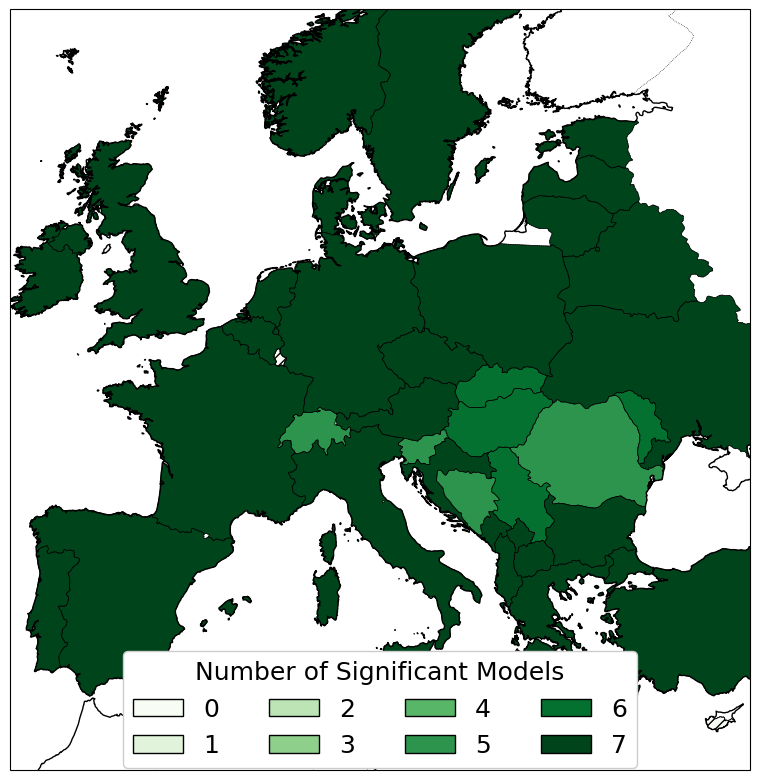

model agreement on Era5-BOC difference in drought days


In [4]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
import matplotlib as mpl

# ─── 1) Load your ERA5 vs BOC per‐country t‐test results ─────────────
power_dir = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power"
csv_path  = os.path.join(power_dir, "country_era5_vs_boc_drought_days.csv")
df = pd.read_csv(csv_path)
# columns: model, country (ISO3), mean_era5, mean_boc, shapiro_era5, shapiro_boc, ttest_p, significant

# ─── 2) Count how many models show a significant difference ───────────
counts = (
    df[df["significant"]]
      .groupby("country")["model"]
      .nunique()
      .rename("n_models_significant")
      .reset_index()
)

# ─── 3) Build full list of ISO3 codes you care about ────────────────
EU27 = [
    'AUT','BEL','BGR','HRV','CYP','CZE','DNK','EST','FRA','DEU','GRC',
    'HUN','IRL','ITA','LVA','LTU','LUX','MLT','NLD','POL','PRT','ROU',
    'SVK','SVN','ESP','SWE'
]
extras = [
    'GBR','NOR','BIH','MNE','SRB','ALB','MKD','CHE','ISL','TUR',
    'UKR','BLR','MDA','KOS'
]
all_iso3 = EU27 + extras

summary = (
    pd.DataFrame({"ADM0_A3": all_iso3})
      .merge(counts.rename(columns={"country":"ADM0_A3"}), on="ADM0_A3", how="left")
      .fillna({"n_models_significant": 0})
      .astype({"n_models_significant": "int"})
)

# ─── 4) Load country geometries & force‐map Kosovo ───────────────────
ne50  = "https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip"
world = gpd.read_file(ne50).set_crs("EPSG:4326")

# Natural Earth uses "RKS" or None, so override:
world.loc[world.ADM0_A3 == "RKS", "ADM0_A3"] = "KOS"

eu = world[world.ADM0_A3.isin(all_iso3)][["ADM0_A3","geometry"]].copy()

# ─── 5) Merge shapes with our model‐agreement counts ────────────────
gdf = eu.merge(summary, on="ADM0_A3", how="left")

# ─── 6) Plot ───────────────────────────────────────────────────────
fig, ax = plt.subplots(
    figsize=(12, 8),
    subplot_kw={"projection": ccrs.PlateCarree()}
)
ax.set_extent([-10.5, 35, 33, 64], ccrs.PlateCarree())
ax.coastlines("10m", linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.5)

lat0 = (33 + 64) / 2.0
ax.set_aspect(1.0 / np.cos(np.deg2rad(lat0)))

# discrete Greens map for 0–7 models
cmap = plt.get_cmap("Greens", 8)
norm = mpl.colors.BoundaryNorm(np.arange(9)-0.5, ncolors=8)

# main fill
gdf.plot(
    column="n_models_significant",
    cmap=cmap, norm=norm,
    linewidth=0.5, edgecolor="black",
    ax=ax,
    missing_kwds={"color":"lightgrey"}
)
# hatch where fewer than 5 agree
low = gdf[gdf["n_models_significant"] < 5]
low.plot(
    facecolor="none",
    edgecolor="black",
    hatch="///",
    linewidth=0.5,
    ax=ax,
    zorder=3
)

lat0 = (33 + 64) / 2.0
ax.set_aspect(1.0/np.cos(np.deg2rad(lat0)))


# legend
patches = [
    mpatches.Patch(facecolor=cmap(i), edgecolor="black",
                   label=f"{i}")
    for i in range(8)
]
ax.legend(
    handles=patches,
    title="Number of Significant Models",
    loc="center",
    ncol=4,
    bbox_to_anchor=(0.5, 0.08),
    borderaxespad=0.,
    frameon=True,
    title_fontsize=18,
    fontsize=18, framealpha = 1
)
plt.tight_layout()
#plt.savefig("/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/figures/era5_drought_agreement.pdf", bbox_inches='tight', dpi=300)
plt.show()


/tmp/ipykernel_56181/2942474176.py:134: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


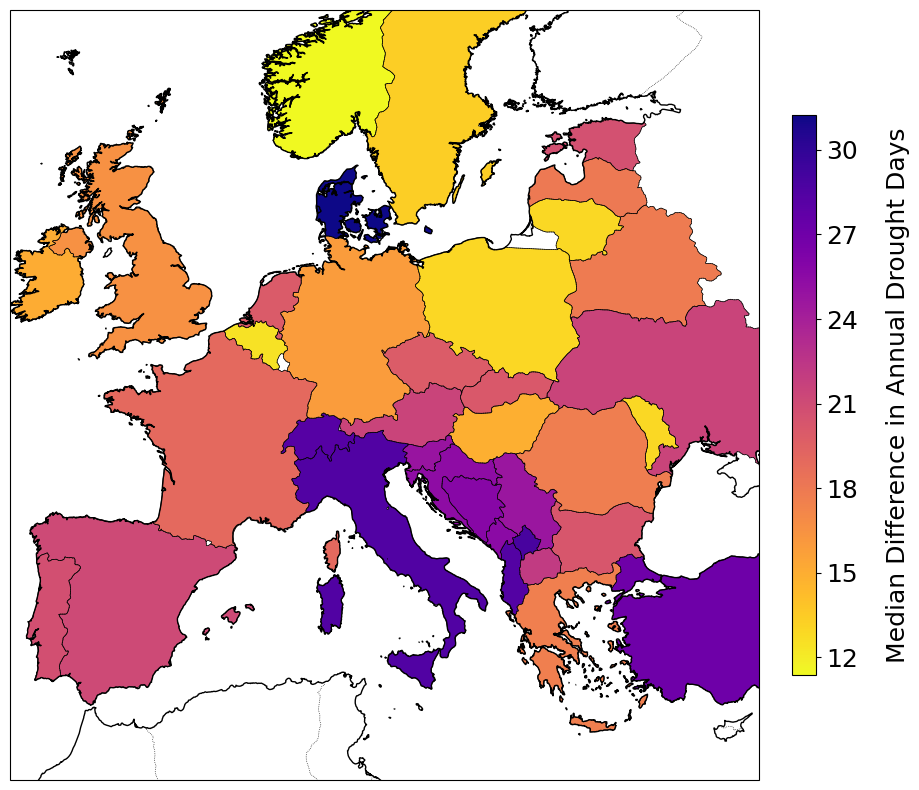

BOC-ERA5 difference in annual drought days


In [5]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches

# ─── 1) Read your ERA5 vs BOC test results ───────────────────────────
base_dir = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power"
csv_path = os.path.join(base_dir, "country_era5_vs_boc_drought_days.csv")
df = pd.read_csv(csv_path)
# columns: model, country (ISO3), mean_era5, mean_boc, shapiro_era5, shapiro_boc, ttest_p, significant

# ─── 2) Compute per‐country metrics (ISO3 keys) ──────────────────────
# 2a) median difference (model minus ERA5) in drought‐days
df["diff"] = df["mean_boc"] - df["mean_era5"]
med_diff = (
    df.groupby("country")["diff"]
      .median()
      .rename("median_diff")
      .reset_index()
)

# 2b) how many models flagged significant
counts = (
    df[df["significant"]]
      .groupby("country")["model"]
      .nunique()
      .rename("n_models_significant")
      .reset_index()
)

# ─── 3) Full list of ISO3 codes ───────────────────────────────────────
EU27   = ['AUT','BEL','BGR','HRV','CZE','DNK','EST','FRA','DEU','GRC',
          'HUN','IRL','ITA','LVA','LTU','NLD','POL','PRT','ROU',
          'SVK','SVN','ESP','SWE']
extras = ['GBR','NOR','BIH','MNE','SRB','ALB','MKD','CHE','TUR','UKR','BLR','MDA','KOS']
all_iso3 = EU27 + extras

# ─── 4) Assemble summary ─────────────────────────────────────────────
summary = (
    pd.DataFrame({"ADM0_A3": all_iso3})
      .merge(med_diff.rename(columns={"country":"ADM0_A3"}), on="ADM0_A3", how="left")
      .merge(counts   .rename(columns={"country":"ADM0_A3"}), on="ADM0_A3", how="left")
      .fillna({"median_diff":0.0, "n_models_significant":0})
      .astype({"n_models_significant":"int"})
)

# ─── 5) Load Natural Earth & extract Europe+extras ───────────────────
ne50  = "https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip"
world = gpd.read_file(ne50).set_crs("EPSG:4326")
# force-map Kosovo and Türkiye codes
world.loc[world.ADM0_A3 == "RKS", "ADM0_A3"] = "KOS"
world.loc[world.NAME_LONG == "Türkiye", "ADM0_A3"]    = "TUR"

eu = world[world.ADM0_A3.isin(all_iso3)][["ADM0_A3","geometry"]].copy()

# ─── 6) Merge geometries + summary ──────────────────────────────────
gdf = eu.merge(summary, on="ADM0_A3", how="left")
gdf["n_models_significant"] = gdf["n_models_significant"].fillna(0).astype(int)
gdf["median_diff"]          = gdf["median_diff"].fillna(0.0)

# dissolve multi‐part countries by max‐count
gdf = (
    gdf.dissolve(
        by="ADM0_A3",
        aggfunc={"n_models_significant":"max","median_diff":"first"}
    )
    .reset_index()
)

# ─── 7) Colormap setup ───────────────────────────────────────────────
vmin, vmax = gdf["median_diff"].min(), gdf["median_diff"].max()
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.get_cmap("plasma_r")

# … after dissolve() …
gdf["n_models_significant"] = gdf["n_models_significant"].fillna(0).astype(int)
gdf["median_diff"]          = gdf["median_diff"].fillna(0.0)

# Mask those with zero agreement to NaN
gdf.loc[gdf["n_models_significant"] == 0, "median_diff"] = np.nan

# Mask zero‐agreement countries to NaN so they plot grey
gdf.loc[gdf.n_models_significant == 0, "median_diff"] = np.nan

# ─── 8) Plot ────────────────────────────────────────────────────────
fig, ax = plt.subplots(
    1, 1,
    figsize=(12, 8),
    subplot_kw={"projection": ccrs.PlateCarree()}
)
ax.set_extent([-10.5, 35, 33, 64], ccrs.PlateCarree())
ax.coastlines("10m", linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.5)

# main choropleth: NaN → missing_kwds color
gdf.plot(
    column="median_diff",
    cmap=cmap, norm=norm,
    linewidth=0.5, edgecolor="black",
    ax=ax,
    missing_kwds={"color":"white"}
)

# only hatch if there *are* any low‐agreement countries
low = gdf[(gdf.n_models_significant > 0) & (gdf.n_models_significant < 5)]
if not low.empty:
    low.plot(
        facecolor="none", edgecolor="black",
        hatch="///", linewidth=0.5,
        ax=ax, zorder=3
    )
lat0 = (33+64)/2
ax.set_aspect(1/np.cos(np.deg2rad(lat0)))


plt.subplots_adjust(right=0.85)
cax = fig.add_axes([0.84, 0.15, 0.02, 0.7])
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
#ticks = np.linspace(vmin, vmax, 6)
#cbar.set_ticks(ticks)
cbar.ax.tick_params(labelsize=18)
cbar.set_label("Median Difference in Annual Drought Days", fontsize=18, labelpad=20)
import matplotlib.ticker as mticker
cbar.locator = mticker.MaxNLocator(nbins=7, integer=True)
cbar.update_ticks()

plt.tight_layout()
#plt.savefig("/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/figures/ERA5_diff_drought_days.pdf", bbox_inches='tight', dpi=300)
plt.show()
print("BOC-ERA5 difference in annual drought days")

In [6]:
import os
# ─── 1) Read your ERA5 vs BOC test results ───────────────────────────
base_dir = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power"
csv_path = os.path.join(base_dir, "country_era5_vs_boc_drought_days.csv")
df = pd.read_csv(csv_path)
# columns: model, country (ISO3), mean_era5, mean_boc, shapiro_era5, shapiro_boc, ttest_p, significant

# ─── 2) Compute per‐country metrics (ISO3 keys) ──────────────────────
# 2a) median difference (model minus ERA5) in drought‐days
med_era5 = (
    df.groupby("country")["mean_era5"]
      .median()
      .reset_index()
)
med_boc= (
    df.groupby("country")["mean_boc"]
      .median()
      .reset_index())

# ─── 3) Full list of ISO3 codes ───────────────────────────────────────
EU27   = ['AUT','BEL','BGR','HRV','CZE','DNK','EST','FRA','DEU','GRC',
          'HUN','IRL','ITA','LVA','LTU','NLD','POL','PRT','ROU',
          'SVK','SVN','ESP','SWE']
extras = ['GBR','NOR','BIH','MNE','SRB','ALB','MKD','CHE','TUR','UKR','BLR','MDA','KOS']
all_iso3 = EU27 + extras

# ─── 4) Assemble summary ─────────────────────────────────────────────
summary = (
    pd.DataFrame({"ADM0_A3": all_iso3})
      .merge(med_era5.rename(columns={"country":"ADM0_A3"}), on="ADM0_A3", how="left")
      .merge(med_boc.rename(columns={"country":"ADM0_A3"}), on="ADM0_A3", how="left")
)

# ─── 5) Load Natural Earth & extract Europe+extras ───────────────────
ne50  = "https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip"
world = gpd.read_file(ne50).set_crs("EPSG:4326")
# force-map Kosovo and Türkiye codes
world.loc[world.ADM0_A3 == "RKS", "ADM0_A3"] = "KOS"
world.loc[world.NAME_LONG == "Türkiye", "ADM0_A3"]    = "TUR"

eu = world[world.ADM0_A3.isin(all_iso3)][["ADM0_A3","geometry"]].copy()

# ─── 6) Merge geometries + summary ──────────────────────────────────
gdf = eu.merge(summary, on="ADM0_A3", how="left")

# dissolve multi‐part countries by max‐count
gdf = (
    gdf.dissolve(
        by="ADM0_A3",
        aggfunc={"mean_era5":"first", "mean_boc":  "first"},
    )
    .reset_index()
)

# ─── 7) Colormap setup ───────────────────────────────────────────────
vmin, vmax = gdf["mean_era5"].min(), gdf["mean_era5"].max()
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)



/tmp/ipykernel_56181/2202995204.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


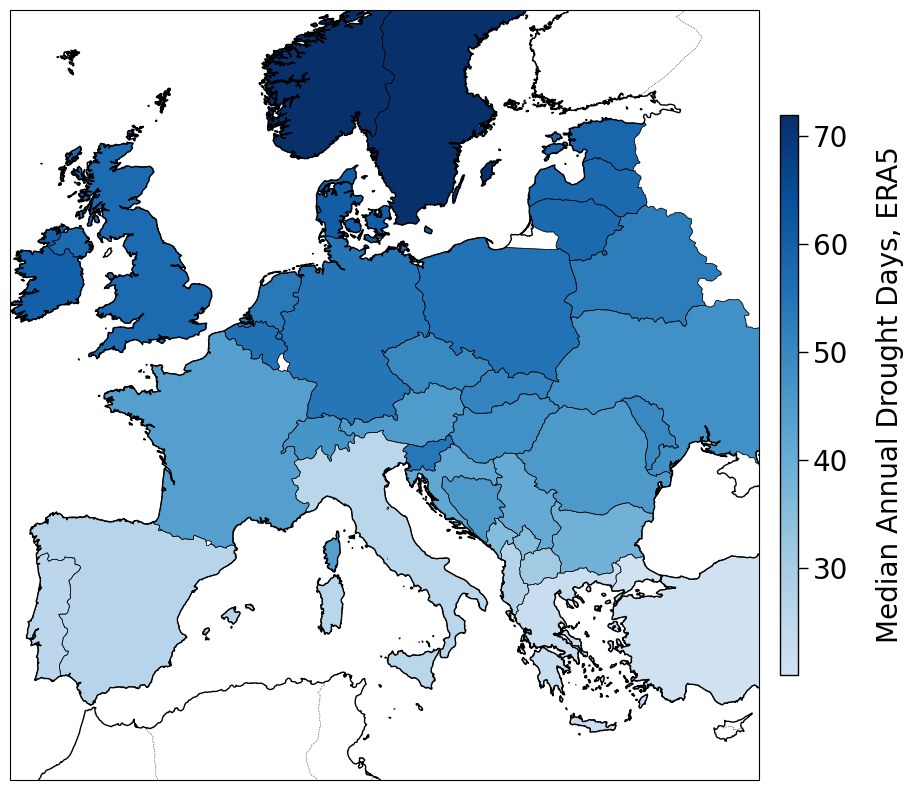

In [7]:
# ─── 8) Plot ────────────────────────────────────────────────────────
from matplotlib.cm import ScalarMappable
cmap = plt.get_cmap("Blues")
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
new_colors = cmap(np.linspace(0.2, 1.0, 256))
trunc_blues = LinearSegmentedColormap.from_list("Blues_no_white", new_colors)
cmap = trunc_blues
fig, ax = plt.subplots(
    1, 1,
    figsize=(12, 8),
    subplot_kw={"projection": ccrs.PlateCarree()}
)
ax.set_extent([-10.5, 35, 33, 64], ccrs.PlateCarree())
ax.coastlines("10m", linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.5)

# main choropleth: NaN → missing_kwds color
gdf.plot(
    column="mean_era5",
    cmap=cmap, norm=norm,
    linewidth=0.5, edgecolor="black",
    ax=ax,
    missing_kwds={"color":"white"}
)
# build the colorbar
# preserve aspect
lat0 = (33 + 64) / 2
ax.set_aspect(1 / np.cos(np.deg2rad(lat0)))

# make room on right
plt.subplots_adjust(right=0.82)

# add a slimmer cbar axes [left, bottom, width, height]
cax = fig.add_axes([0.83, 0.15, 0.015, 0.7])

# build the ScalarMappable
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm._A = []

# draw cbar
cbar = fig.colorbar(sm, cax=cax)

# outline
cbar.outline.set_edgecolor("black")
cbar.outline.set_linewidth(1)

# integer ticks up to 7
#cbar.locator = mticker.MaxNLocator(nbins=7, integer=True)
#cbar.update_ticks()

# inward ticks, smaller font
cbar.ax.tick_params(direction="out", length=7, width=1, labelsize=20)

# move the descriptive label to the top, as a title
cbar.set_label(
    "Median Annual Drought Days, ERA5",
    fontsize=20,
    rotation=90,            # 270° so it reads bottom→top
    labelpad=20
)
# make sure the label is on the right side
cbar.ax.yaxis.set_label_position("right")

plt.tight_layout()
#plt.savefig("/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/figures/ERA5_yearly_drought_days.pdf", bbox_inches='tight', dpi=300)
plt.show()

/tmp/ipykernel_56181/720221802.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


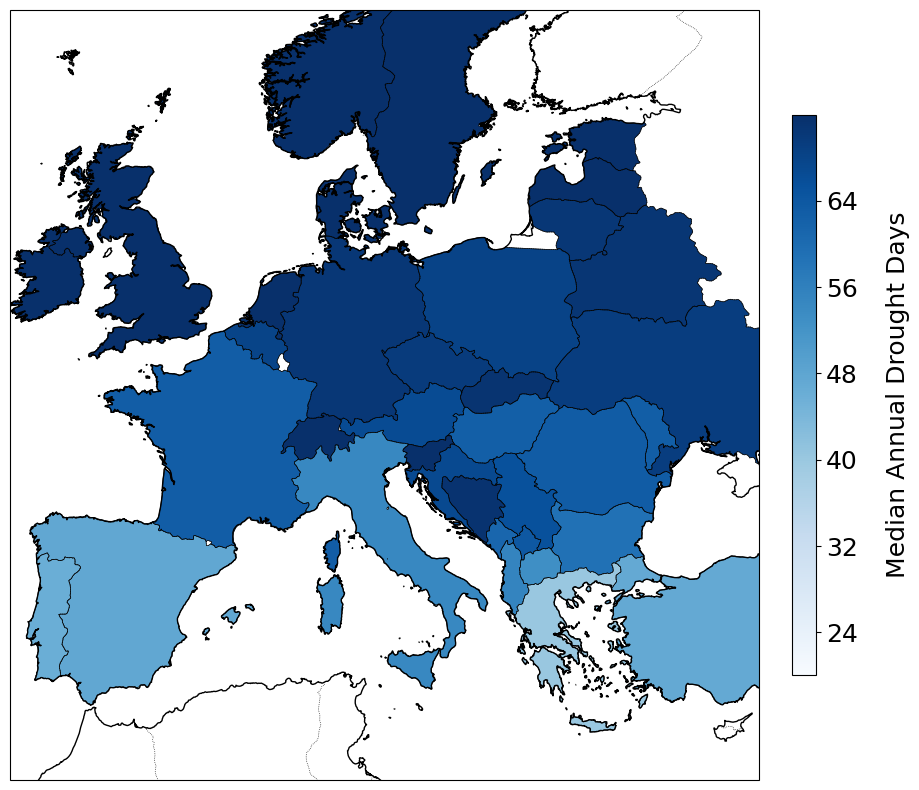

In [8]:
# ─── 8) Plot ────────────────────────────────────────────────────────
cmap="Blues"
fig, ax = plt.subplots(
    1, 1,
    figsize=(12, 8),
    subplot_kw={"projection": ccrs.PlateCarree()}
)
ax.set_extent([-10.5, 35, 33, 64], ccrs.PlateCarree())
ax.coastlines("10m", linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.5)

# main choropleth: NaN → missing_kwds color
gdf.plot(
    column="mean_boc",
    cmap=cmap, norm=norm,
    linewidth=0.5, edgecolor="black",
    ax=ax,
    missing_kwds={"color":"white"}
)

lat0 = (33+64)/2
ax.set_aspect(1/np.cos(np.deg2rad(lat0)))


plt.subplots_adjust(right=0.85)
cax = fig.add_axes([0.84, 0.15, 0.02, 0.7])
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
#ticks = np.linspace(vmin, vmax, 6)
#cbar.set_ticks(ticks)
cbar.ax.tick_params(labelsize=18)
cbar.set_label("Median Annual Drought Days", fontsize=18, labelpad=20)
import matplotlib.ticker as mticker
cbar.locator = mticker.MaxNLocator(nbins=7, integer=True)
cbar.update_ticks()

plt.tight_layout()
#plt.savefig("/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/figures/BOC_yearly_drought_days.pdf", bbox_inches='tight', dpi=300)
plt.show()

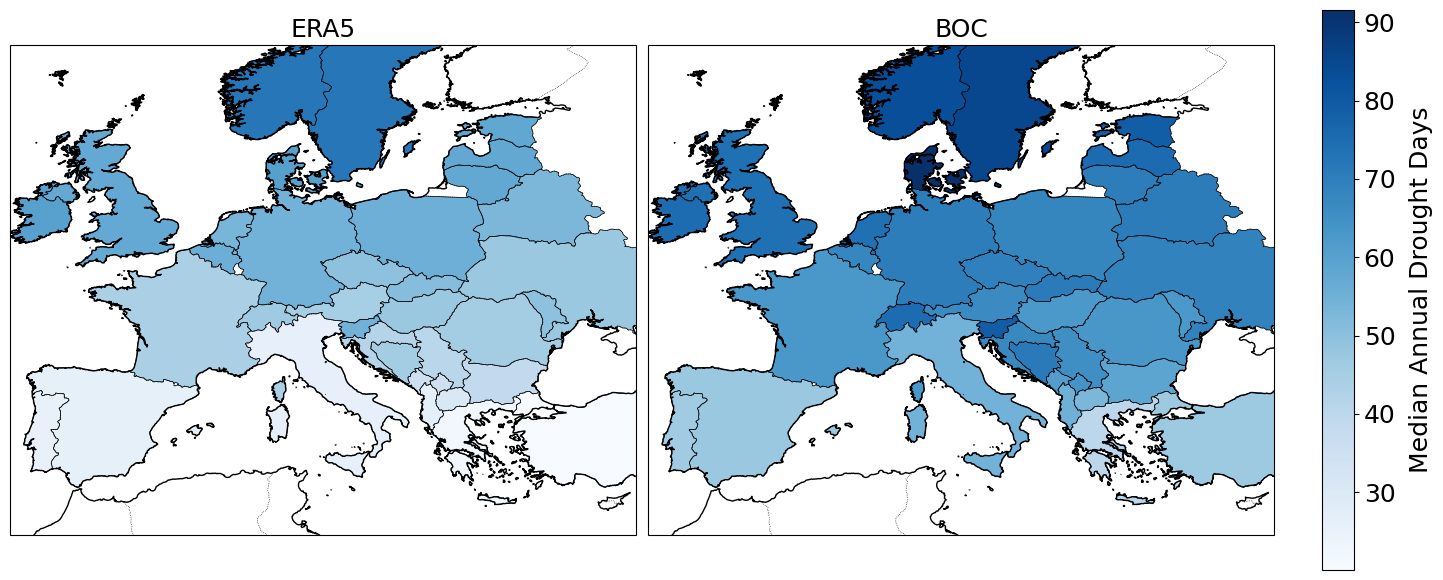

In [9]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# … your data‐prep steps, up through computing gdf with both columns mean_era5 & mean_boc …

# 1) Decide on a common norm across both variables:
vmin = min(gdf['mean_era5'].min(), gdf['mean_boc'].min())
vmax = max(gdf['mean_era5'].max(), gdf['mean_boc'].max())
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.get_cmap("Blues")  # or any other

# 2) Create two subplots, sharing the same projection
fig, (ax1, ax2) = plt.subplots(
    1, 2,
    figsize=(16,8),
    subplot_kw={"projection": ccrs.PlateCarree()},
    gridspec_kw={'left': 0.03,    # little left margin
        'right': 0.82,   # leave room for the colorbar
        'bottom': 0.05,
        'top': 0.95,
        'wspace': 0.02   # shrink the inter‐map gap
        }
)

for ax in (ax1, ax2):
    ax.set_extent([-10.5, 35, 33, 64], ccrs.PlateCarree())
    ax.coastlines("10m", linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.5)
    lat0 = (33 + 64) / 2
    ax.set_aspect(1/np.cos(np.deg2rad(lat0)))
lat0 = (33+64)/2
ax1.set_aspect(1/np.cos(np.deg2rad(lat0)))

# 3a) Plot ERA5 on the left
gdf.plot(
    column="mean_era5",
    cmap=cmap, norm=norm,
    linewidth=0.5, edgecolor="black",
    ax=ax1,
    missing_kwds={"color":"white"}
)
ax1.set_title("ERA5", fontsize=18)

# 3b) Plot BOC on the right
gdf.plot(
    column="mean_boc",
    cmap=cmap, norm=norm,
    linewidth=0.5, edgecolor="black",
    ax=ax2,
    missing_kwds={"color":"white"}
)
ax2.set_title("BOC", fontsize=18)

# 4) Add one shared colorbar to the right
#   adjust subplots to make room for colorbar
plt.subplots_adjust(left=0.03, right=0.85, wspace=0.02)

# colorbar axes
cax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm._A = []  # no data on this mappable directly

cbar = fig.colorbar(sm, cax=cax)
cbar.ax.tick_params(labelsize=18)
cbar.set_label("Median Annual Drought Days", fontsize=18, labelpad=10)

plt.show()


In [11]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import box
from cartopy.io.shapereader import natural_earth
from scipy.stats import shapiro, ttest_ind

# ─── SETTINGS ─────────────────────────────────────────────────────────
power_dir = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power"
era5_dir  = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power_Era5_h_1x1"
models    = [
    "ACCESS-CM2","CanESM5","CMCC-CM2-SR5","CMCC-ESM2",
    "HadGEM3-GC31-LL","HadGEM3-GC31-MM","MRI-ESM2-0"
]
BOC_tag   = "BOC"    # your BOC CSVs

# ─── 0) load Europe + Turkey shapefile to map cells → country ────────
shp   = natural_earth('110m','cultural','admin_0_countries')
world = gpd.read_file(shp).set_crs("EPSG:4326")
eur   = world[
    (world.CONTINENT=="Europe") | (world.ADM0_A3=="TUR")
][["ADM0_A3","geometry"]].rename(columns={"ADM0_A3":"iso3"})

results = []

for model in models:
    # 1) locate the two event‐csvs
    boc_csv  = os.path.join(
        power_dir, f"{model}_1x1grid/historical/solar_drought_events_{BOC_tag}.csv"
    )
    era5_csv = os.path.join(
        era5_dir, f"solar_drought_events.csv"
    )
    if not os.path.exists(boc_csv) or not os.path.exists(era5_csv):
        print(f"⚠️ Missing CSV for {model}, skipping")
        continue

    df_boc  = pd.read_csv(boc_csv)
    df_e5   = pd.read_csv(era5_csv)

    # 2) build grid cell polygons from the union of lats/lons
    lats = np.sort(np.unique(np.concatenate([df_boc.lat, df_e5.lat])))
    lons = np.sort(np.unique(np.concatenate([df_boc.lon, df_e5.lon])))
    dlat, dlon = np.median(np.diff(lats)), np.median(np.diff(lons))

    cells = [
        {
            "lat": lat, "lon": lon,
            "geometry": box(lon-dlon/2, lat-dlat/2, lon+dlon/2, lat+dlat/2)
        }
        for lat in lats for lon in lons
    ]
    cells_gdf = gpd.GeoDataFrame(cells, crs="EPSG:4326")

    # 3) project & intersect to get cell→country map
    cells_eq = cells_gdf.to_crs("EPSG:3035")
    eur_eq   = eur.to_crs("EPSG:3035")
    inter    = gpd.overlay(cells_eq, eur_eq, how="intersection")
    inter["area"] = inter.geometry.area
    idx = inter.groupby(["lat","lon"])["area"].idxmax()
    mapping = inter.loc[idx, ["lat","lon","iso3"]]
    cell2ctry = {(r.lat, r.lon): r.iso3 for _, r in mapping.iterrows()}

    # ─── helper: compute per‐cell, per‐year p75 event duration ──────────
    def cell_year_p75(df_events):
        # group durations per cell×year, compute 75th percentile
        grp = df_events.groupby(["lat","lon","year"])["duration"]
        p75 = grp.quantile(0.75).reset_index(name="p75_dur")
        # map to country
        p75["iso3"] = p75.apply(
            lambda r: cell2ctry.get((r.lat, r.lon), np.nan), axis=1
        )
        return p75.dropna(subset=["iso3"])

    def cell_year_p90(df_events):
        # group durations per cell×year, compute 75th percentile
        grp = df_events.groupby(["lat","lon","year"])["duration"]
        p90 = grp.quantile(0.9).reset_index(name="p90_dur")
        # map to country
        p90["iso3"] = p90.apply(
            lambda r: cell2ctry.get((r.lat, r.lon), np.nan), axis=1
        )
        return p90.dropna(subset=["iso3"])

    #boc_p75 = cell_year_p75(df_boc)
    #e5_p75  = cell_year_p75(df_e5)
    boc_p90 = cell_year_p90(df_boc)
    e5_p90  = cell_year_p90(df_e5)

    # ─── for each country, gather the two 35-year time series & test ────
    for iso in sorted(set(boc_p90.iso3) & set(e5_p90.iso3)):
        xb = boc_p90.loc[boc_p90.iso3==iso, "p90_dur"].values
        xe = e5_p90 .loc[e5_p90.iso3==iso,   "p90_dur"].values

        # need at least 3 years in each
        if len(xb)<3 or len(xe)<3:
            continue

        # skip if flat
        if np.allclose(xb, xb[0]) or np.allclose(xe, xe[0]):
            p_sb = p_se = p_t = np.nan
            sig  = False
        else:
            p_sb = shapiro(xb).pvalue
            p_se = shapiro(xe).pvalue
            _, p_t = ttest_ind(xb, xe, equal_var=False)
            sig    = (p_t < 0.05)

        results.append({
            "model":        model,
            "country":      iso,
            "p90_boc":      np.median(xb),
            "p90_era5":     np.median(xe),
            "shapiro_boc":  p_sb,
            "shapiro_era5": p_se,
            "ttest_p":      p_t,
            "significant":  sig
        })

# ─── save to CSV ─────────────────────────────────────────────────────
out = pd.DataFrame(results)
out_csv = os.path.join(power_dir, "country_era5_vs_boc_p90_tests.csv")
#out.to_csv(out_csv, index=False)
print(f"✅ Written annual p90 drought-duration tests: {out_csv}")


✅ Written annual p90 drought-duration tests: /work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power/country_era5_vs_boc_p90_tests.csv


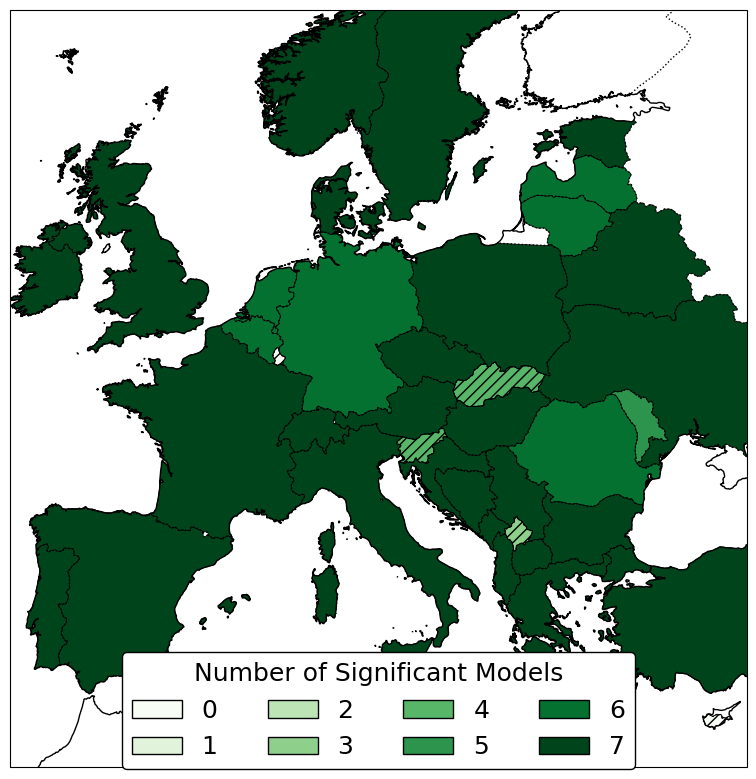

Plot annual p75 results, model agreement era5 boc.


In [12]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
import matplotlib as mpl

# 1) Read your annual p75‐test results (country in ISO3)
df = pd.read_csv(
    "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power/country_era5_vs_boc_p90_tests.csv"
)  # columns: model,country(ISO3),p75_boc,p75_eoc,significant

# 2) Count how many models are significant per ISO3
counts3 = (
    df[df.significant]
      .groupby("country")["model"]
      .nunique()
      .rename("n_models_significant")
      .reset_index()
)

# 3) Build a full list of 3‐letter codes you care about
EU27 = ['AUT','BEL','BGR','HRV','CYP','CZE','DNK','EST','FRA','DEU','GRC',
        'HUN','IRL','ITA','LVA','LTU','LUX','MLT','NLD','POL','PRT','ROU',
        'SVK','SVN','ESP','SWE']
extras = ['GBR','NOR','BIH','MNE','SRB','ALB','MKD','CHE','ISL','TUR','UKR','BLR','MDA','KOS']
all_iso3 = EU27 + extras
summary3 = pd.DataFrame({"ADM0_A3": all_iso3}).merge(
    counts3.rename(columns={"country":"ADM0_A3"}),
    on="ADM0_A3", how="left"
).fillna(0).astype({"n_models_significant":"int"})

# 4) Grab the country shapes keyed by ADM0_A3
ne50  = "https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip"
world = gpd.read_file(ne50).to_crs("EPSG:4326")

# force Kosovo ISO in NaturalEarth
world.loc[world.ADM0_A3 == "RKS","ADM0_A3"] = "KOS"

eu = world[world.ADM0_A3.isin(all_iso3)][["ADM0_A3","geometry"]]

# 5) Merge on the 3‐letter key
gdf = eu.merge(summary3, on="ADM0_A3", how="left")

# 6) Plot
cmap = plt.get_cmap("Greens", 8)
norm = mpl.colors.BoundaryNorm(range(9), 8)

fig, ax = plt.subplots(
    1,1, figsize=(12,8),
    subplot_kw={"projection": ccrs.PlateCarree()}
)
ax.set_extent([-10.5,35,33,64], ccrs.PlateCarree())
ax.coastlines("10m"); ax.add_feature(cfeature.BORDERS, linestyle=":")

gdf.plot(
    column="n_models_significant",
    cmap=cmap, norm=norm,
    linewidth=0.5, edgecolor="black",
    ax=ax,
    missing_kwds={"color":"lightgrey"}
)
low = gdf[gdf.n_models_significant < 5]
low.plot(
    facecolor="none", edgecolor="black",
    hatch="///", linewidth=0.5,
    ax=ax, zorder=3
)

#ax.set_title("Models agreeing on significant change in annual p75 duration of drought events\n between Era5 and BOC from models (hatched if fewer than 5 models)", fontsize=14)

patches = [
    mpatches.Patch(
        facecolor=cmap(i/7), edgecolor='black', label=f"{i}")
    for i in range(8)
]

ax.legend(
    handles=patches, ncol=4,
    title="Number of Significant Models",
    loc="center",
    bbox_to_anchor=(0.5,0.075),
    borderaxespad=0., fontsize=18, title_fontsize=18, frameon=True,
    framealpha = 1. , edgecolor='black'
)
lat0 = (33+64)/2
ax.set_aspect(1/np.cos(np.deg2rad(lat0)))

plt.tight_layout()
#plt.savefig("/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/figures/agreement_era5_BOC_duration_P90.pdf", bbox_inches='tight', dpi=300)
plt.show()

print("Plot annual p75 results, model agreement era5 boc.")

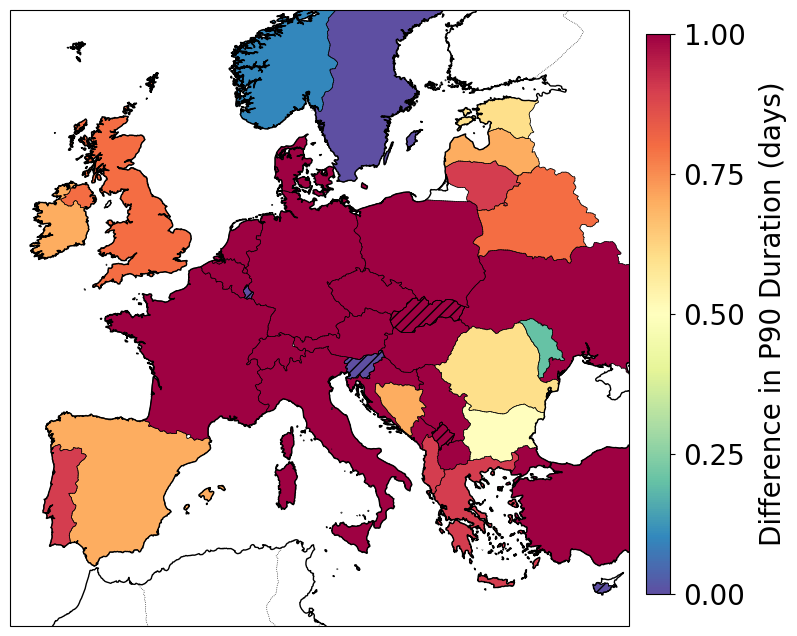

In [13]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl

# 1) Load your annual p75‐test CSV
base_dir = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power"
csv_path = os.path.join(base_dir, "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power/country_era5_vs_boc_p90_tests.csv")
df = pd.read_csv(csv_path)
# df columns: model, country (ISO3), p75_boc, p75_eoc, shapiro_boc, shapiro_eoc, ttest_p, significant

# 2) Compute per‐country metrics (3‐letter ISO keys)
# 2a) median difference in p75
df["diff"] = df["p90_boc"] - df["p90_era5"]
med_diff = (
    df.groupby("country")["diff"]
      .median()
      .rename("median_diff")
      .reset_index()
)

# 2b) number of models flagged significant
counts3 = (
    df[df.significant]
      .groupby("country")["model"]
      .nunique()
      .rename("n_models_significant")
      .reset_index()
)

# 3) Full list of ISO3 codes
EU27   = ['AUT','BEL','BGR','HRV','CYP','CZE','DNK','EST','FRA','DEU','GRC',
          'HUN','IRL','ITA','LVA','LTU','LUX','MLT','NLD','POL','PRT','ROU',
          'SVK','SVN','ESP','SWE']
extras = ['GBR','NOR','BIH','MNE','SRB','ALB','MKD','CHE','ISL','TUR','UKR','BLR','MDA','KOS']
all_iso3 = EU27 + extras

# 4) Assemble summary3 with both metrics
summary3 = pd.DataFrame({"ADM0_A3": all_iso3})\
    .merge(med_diff.rename(columns={"country":"ADM0_A3"}), on="ADM0_A3", how="left")\
    .merge(counts3.rename(columns={"country":"ADM0_A3"}), on="ADM0_A3", how="left")\
    .fillna({"median_diff":0.0, "n_models_significant":0})\
    .astype({"n_models_significant":"int"})

# 5) Load Natural Earth & extract only our region
ne50  = "https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip"
world = gpd.read_file(ne50).set_crs("EPSG:4326")
# fix Kosovo code
world.loc[world.ADM0_A3 == "RKS", "ADM0_A3"] = "KOS"
eu = world[world.ADM0_A3.isin(all_iso3)][["ADM0_A3","geometry"]]

# 6) Merge geometries + summary3
gdf = eu.merge(summary3, on="ADM0_A3", how="left")

# 7) Build colormap clipped at 5–95% of median_diff
vmin = gdf["median_diff"].min()
vmax = gdf["median_diff"].max()
#norm = mpl.colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.get_cmap("Spectral_r")
#cmap = plt.get_cmap("coolwarm")

# 8) Plot
fig, ax = plt.subplots(
    1, 1,
    figsize=(12, 8),
    subplot_kw={"projection": ccrs.PlateCarree()}
)
ax.set_extent([-12, 35, 33, 64], ccrs.PlateCarree())
ax.coastlines("10m", linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.5)

# main choropleth
gdf.plot(
    column="median_diff",
    cmap=cmap, norm=norm,
    linewidth=0.5, edgecolor="black",
    ax=ax,
    missing_kwds={"color":"lightgrey"}
)

# hatch countries with < 5 agreeing models
low = gdf[gdf.n_models_significant < 5]
low.plot(
    facecolor="none", edgecolor="black",
    hatch="///", linewidth=0.5,
    ax=ax, zorder=3
)

lat0 = (33+64)/2
ax.set_aspect(1/np.cos(np.deg2rad(lat0)))
#ax.set_title("Difference in p75 Drought Duration (days), BOC-Era5, \n (hatched if model agreement <5)", fontsize=16)

# 9) Colorbar to the right, outside map
# push whole map a bit left
plt.subplots_adjust(right=0.99)

cax = fig.add_axes([0.83, 0.15, 0.02, 0.7])  
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
# explicitly set & format ticks
ticks = np.linspace(norm.vmin, norm.vmax, 5)
cbar.set_ticks(ticks)
cbar.ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.2f"))
cbar.ax.tick_params(labelsize=20)
cbar.ax.tick_params(pad=6)

cbar.set_label("Difference in P90 Duration (days)", fontsize=20, labelpad=10)
plt.savefig("/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/figures/difference_p90_era5_boc.pdf", bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import box
from cartopy.io.shapereader import natural_earth
from scipy.stats import shapiro, ttest_ind

# ─── SETTINGS ─────────────────────────────────────────────────────────
power_dir = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power"
era5_dir  = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power_Era5_h_1x1"
models    = [
    "ACCESS-CM2","CanESM5","CMCC-CM2-SR5","CMCC-ESM2",
    "HadGEM3-GC31-LL","HadGEM3-GC31-MM","MRI-ESM2-0"
]
seasons   = ["Winter","Spring","Summer","Autumn"]
BOC_template = os.path.join(power_dir, "{model}_1x1grid", "historical", "solar_drought_events_BOC.csv")
ERA5_csv     = os.path.join(era5_dir, "solar_drought_events.csv")

# ─── PREPARE EUROPE+TURKEY SHAPE ───────────────────────────────────────
shp     = natural_earth("110m", "cultural", "admin_0_countries")
world   = gpd.read_file(shp).set_crs("EPSG:4326")
# include all Europe plus TUR key
europe = world[
    (world.CONTINENT == "Europe") |
    (world.ADM0_A3 == "TUR")
][["ADM0_A3","geometry"]].rename(columns={"ADM0_A3":"iso3"})

all_results = []

for model in models:
    boc_csv = BOC_template.format(model=model)
    if not os.path.isfile(boc_csv):
        print(f"⚠️  Missing BOC CSV for {model}, skipping")
        continue
    if not os.path.isfile(ERA5_csv):
        raise FileNotFoundError("ERA5 CSV not found at: " + ERA5_csv)

    # ─── 1) Load events
    df_boc = pd.read_csv(boc_csv)
    df_e5  = pd.read_csv(ERA5_csv)

    # ─── 2) Build lat/lon→cell polygons
    lats = np.sort(np.unique(np.r_[df_boc.lat, df_e5.lat]))
    lons = np.sort(np.unique(np.r_[df_boc.lon, df_e5.lon]))
    dlat, dlon = np.median(np.diff(lats)), np.median(np.diff(lons))

    cells = []
    for lat in lats:
        for lon in lons:
            cells.append({
                "lat":lat, "lon":lon,
                "geometry": box(lon-dlon/2, lat-dlat/2,
                                lon+dlon/2, lat+dlat/2)
            })
    cells_gdf = gpd.GeoDataFrame(cells, crs="EPSG:4326")

    # reproject to equal‐area and intersect with europe+TUR
    cells_eq = cells_gdf.to_crs("EPSG:3035")
    eur_eq   = europe.to_crs("EPSG:3035")
    inter    = gpd.overlay(cells_eq, eur_eq, how="intersection")
    inter["area"] = inter.geometry.area

    # pick for each cell the country with max overlap
    idx       = inter.groupby(["lat","lon"])["area"].idxmax()
    mapping   = inter.loc[idx, ["lat","lon","iso3"]]
    cell2ctry = { (r.lat, r.lon): r.iso3 for _,r in mapping.iterrows() }

    # ─── helper to get country×year avg drought‐days for one season
    def country_year_days(df_events, season):
        df_s = df_events[df_events.season == season]
        cyr  = df_s.groupby(["lat","lon","year"])["duration"]\
                   .sum().reset_index(name="days")
        cyr["iso3"] = cyr.apply(lambda r: cell2ctry.get((r.lat,r.lon), np.nan), axis=1)
        cyr = cyr.dropna(subset=["iso3"])
        return cyr.groupby(["iso3","year"])["days"]\
                  .mean().reset_index(name="mean_days")

    # ─── 3) For each season compute stats
    for season in seasons:
        boc_ts = country_year_days(df_boc, season)
        e5_ts  = country_year_days(df_e5,  season)
        merged = boc_ts.merge(e5_ts, on=["iso3","year"], suffixes=("_boc","_era5"))

        for iso in merged.iso3.unique():
            sub = merged[merged.iso3 == iso]
            x = sub["mean_days_era5"].values
            y = sub["mean_days_boc"].values

            if len(x) < 3 or len(y) < 3:
                continue

            if np.allclose(x, x[0]) or np.allclose(y, y[0]):
                p_e = p_b = p_t = np.nan
                sig = False
            else:
                p_e = shapiro(x).pvalue
                p_b = shapiro(y).pvalue
                _, p_t = ttest_ind(x, y, equal_var=False)
                sig = p_t < 0.05

            all_results.append({
                "model":         model,
                "country_ISO3":  iso,
                "season":        season,
                "mean_era5_days": float(np.mean(x)),
                "mean_boc_days":  float(np.mean(y)),
                "shapiro_era5_p": p_e,
                "shapiro_boc_p":  p_b,
                "diff_days":      float(np.mean(y) - np.mean(x)),
                "ttest_p":        p_t,
                "significant":    sig
            })

# ─── 4) Save out CSV ─────────────────────────────────────────────────
out_df  = pd.DataFrame(all_results)
out_csv = os.path.join(power_dir, "country_seasonal_era5_vs_boc_days.csv")
#out_df.to_csv(out_csv, index=False)
print(f"✅ Written seasonal ERA5 vs BOC drought‐day stats (incl. TUR) to:\n   {out_csv}")



✅ Written seasonal ERA5 vs BOC drought‐day stats (incl. TUR) to:
   /work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/country_seasonal_era5_vs_boc_days.csv


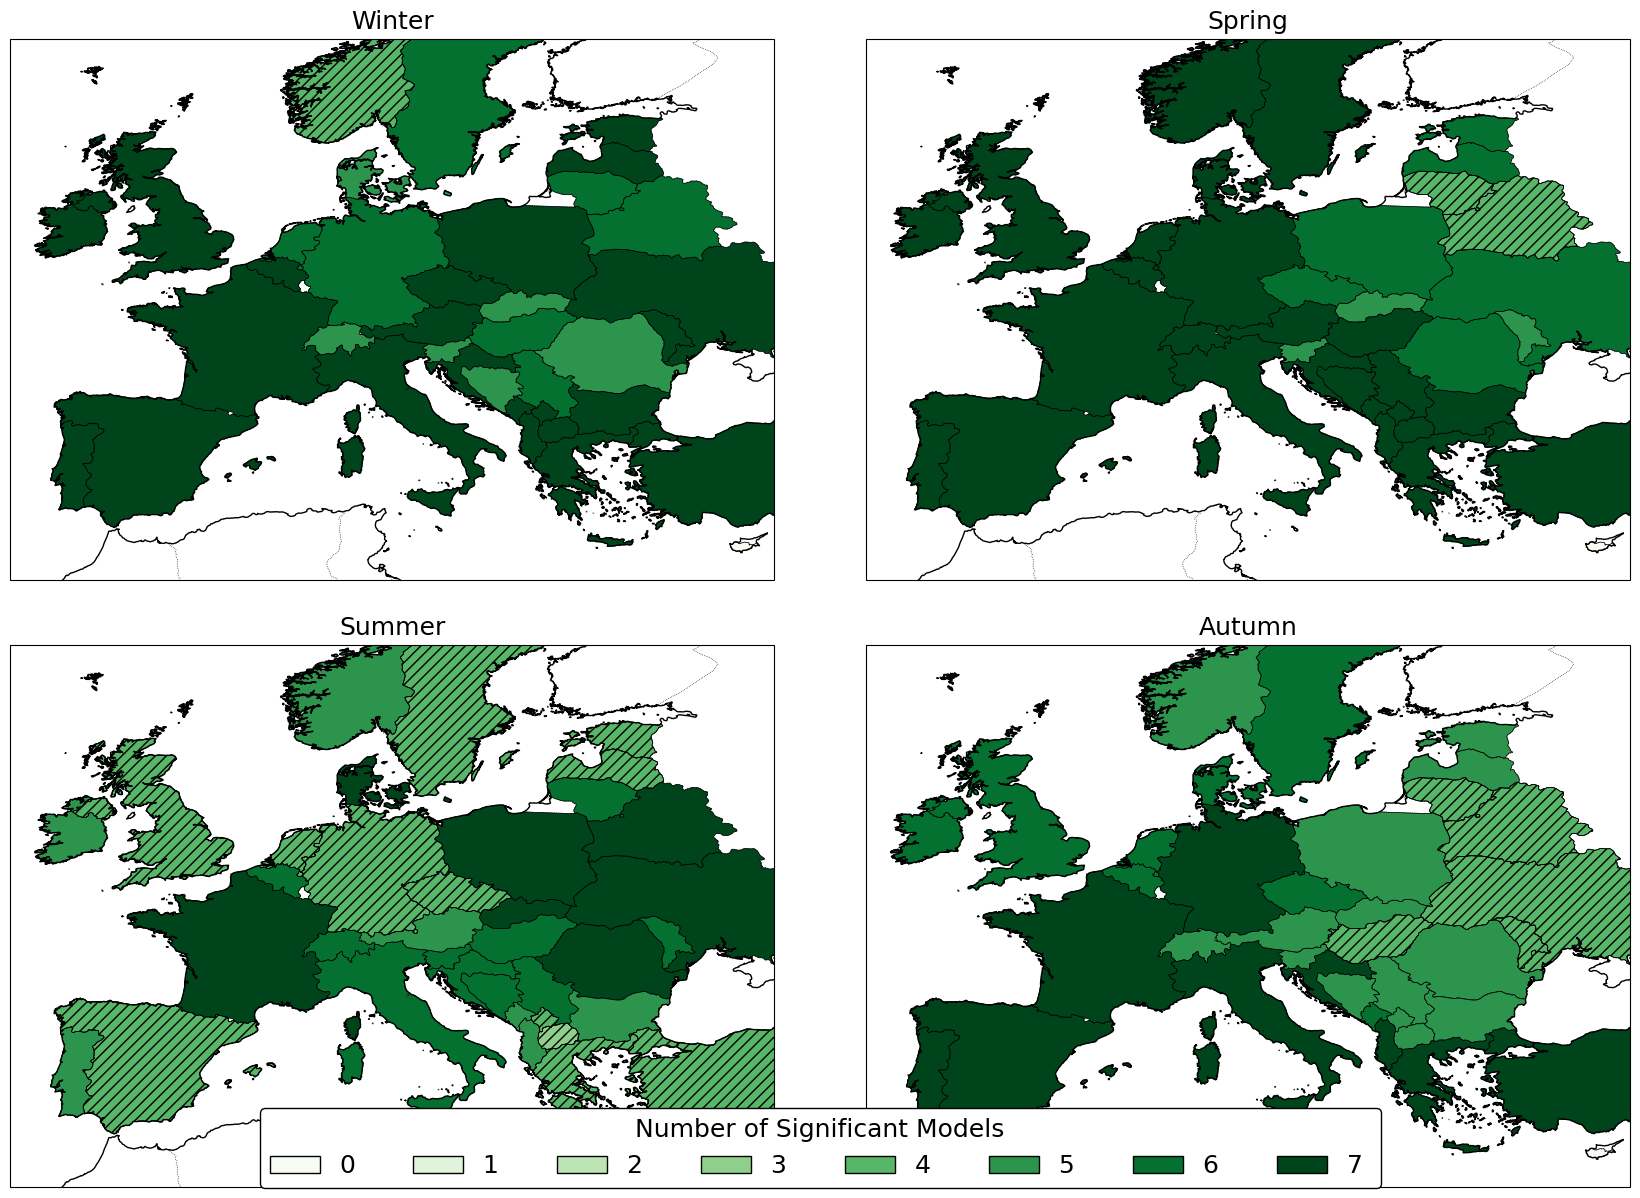

seasonal drought days diffeerence model agreement


In [15]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
import matplotlib as mpl
import pycountry

# ─── 1) Load your ERA5 vs BOC seasonal stats ─────────────────────────
power_dir = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power"
stats_csv = os.path.join(power_dir, "country_seasonal_era5_vs_boc_days.csv")
df = pd.read_csv(stats_csv)
# expects columns: model, country_ISO3, season, ..., significant

# ─── 2) Map ISO3→ISO2 for plotting with NaturalEarth geometries ─────
def iso3_to_iso2(iso3):
    if iso3 == "KOS": return "XK"
    if iso3 == "MKD": return "MK"
    try:
        return pycountry.countries.get(alpha_3=iso3).alpha_2
    except:
        return None

df["ISO_A2"] = df["country_ISO3"].map(iso3_to_iso2)
df = df.dropna(subset=["ISO_A2"])

# ─── 2) Count per country_ISO3×season how many models are significant ─
seasons = ["Winter","Spring","Summer","Autumn"]
counts = (
    df[df["significant"]]
      .groupby(["country_ISO3","season"])["model"]
      .nunique()
      .reset_index(name="n_models_significant")
)

# ensure every combination appears
EU27 = ['AUT','BEL','BGR','HRV','CYP','CZE','DNK','EST','FRA','DEU','GRC',
        'HUN','IRL','ITA','LVA','LTU','LUX','MLT','NLD','POL','PRT','ROU',
        'SVK','SVN','ESP','SWE']
extras = ['GBR','NOR','BIH','MNE','SRB','ALB','MKD','CHE','ISL','TUR','UKR','BLR','MDA','KOS']
all_iso3 = EU27 + extras

full = pd.MultiIndex.from_product([all_iso3, seasons], names=["country_ISO3","season"])
counts = (
    counts
      .set_index(["country_ISO3","season"])
      .reindex(full, fill_value=0)
      .reset_index()
)

# ─── 3) Load Natural Earth by ISO3 ──────────────────────────────────
ne50  = "https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip"
world = gpd.read_file(ne50).set_crs("EPSG:4326")

# force-correct Kosovo and Türki‌ye
world.loc[world.ADM0_A3=="RKS",      "ADM0_A3"] = "KOS"
world.loc[world.NAME_LONG=="Türkiye","ADM0_A3"] = "TUR"

# subset to our list
eu = world[world.ADM0_A3.isin(all_iso3)][["ADM0_A3","geometry"]].rename(columns={"ADM0_A3":"country_ISO3"})

# ─── 4) Merge geometries + counts ───────────────────────────────────
gdf = eu.merge(counts, on="country_ISO3", how="left")
gdf["n_models_significant"] = gdf["n_models_significant"].fillna(0).astype(int)

# ─── 5) Prepare colormap ────────────────────────────────────────────
max_models = df["model"].nunique()
cmap = plt.get_cmap("Greens", max_models+1)
norm = mpl.colors.BoundaryNorm(np.arange(max_models+2)-0.5, max_models+1)

# ─── 6) Plot 2×2 panel ──────────────────────────────────────────────
fig, axes = plt.subplots(
    2, 2, figsize=(18, 14),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

for ax, season in zip(axes.flat, seasons):
    sub = gdf[gdf["season"]==season]
    sub.plot(
        column="n_models_significant",
        cmap=cmap, norm=norm,
        linewidth=0.5, edgecolor="black",
        ax=ax,
        missing_kwds={"color":"lightgrey"}
    )
    low = sub[(sub["n_models_significant"]>0)&(sub["n_models_significant"]<5)]
    if not low.empty:
        low.plot(
            facecolor="none", edgecolor="black",
            hatch="///", linewidth=0.5,
            ax=ax, zorder=3
        )
    ax.coastlines("10m", linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.5)
    ax.set_extent([-12,35,33,64], ccrs.PlateCarree())
    ax.set_aspect("auto")
    ax.set_title(season, fontsize=18, pad=7)

# ─── 7) Add shared legend & title ──────────────────────────────────
fig.subplots_adjust(left=0.03, right=0.82, top=0.90, bottom=0.08,
                    wspace=0.12, hspace=0.12)

fig.subplots_adjust(left=0.05, right=0.95, top=0.90, bottom=0.08,
                    wspace=0.12, hspace=0.12)

patches = [
    mpatches.Patch(facecolor=cmap(i), edgecolor="black",
                   label=f"{i} ")
    for i in range(max_models+1)
]
fig.legend(
    handles=patches,
    title="Number of Significant Models",
    loc="lower center",
    ncol=8, fontsize=18, title_fontsize=18,
    frameon=True, edgecolor="black",
    bbox_to_anchor=(0.5,0.07), framealpha=1
)
#plt.savefig("/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/figures/ERA5_seasonal_agreement.pdf", bbox_inches='tight', dpi=300)
plt.show()
print("seasonal drought days diffeerence model agreement")

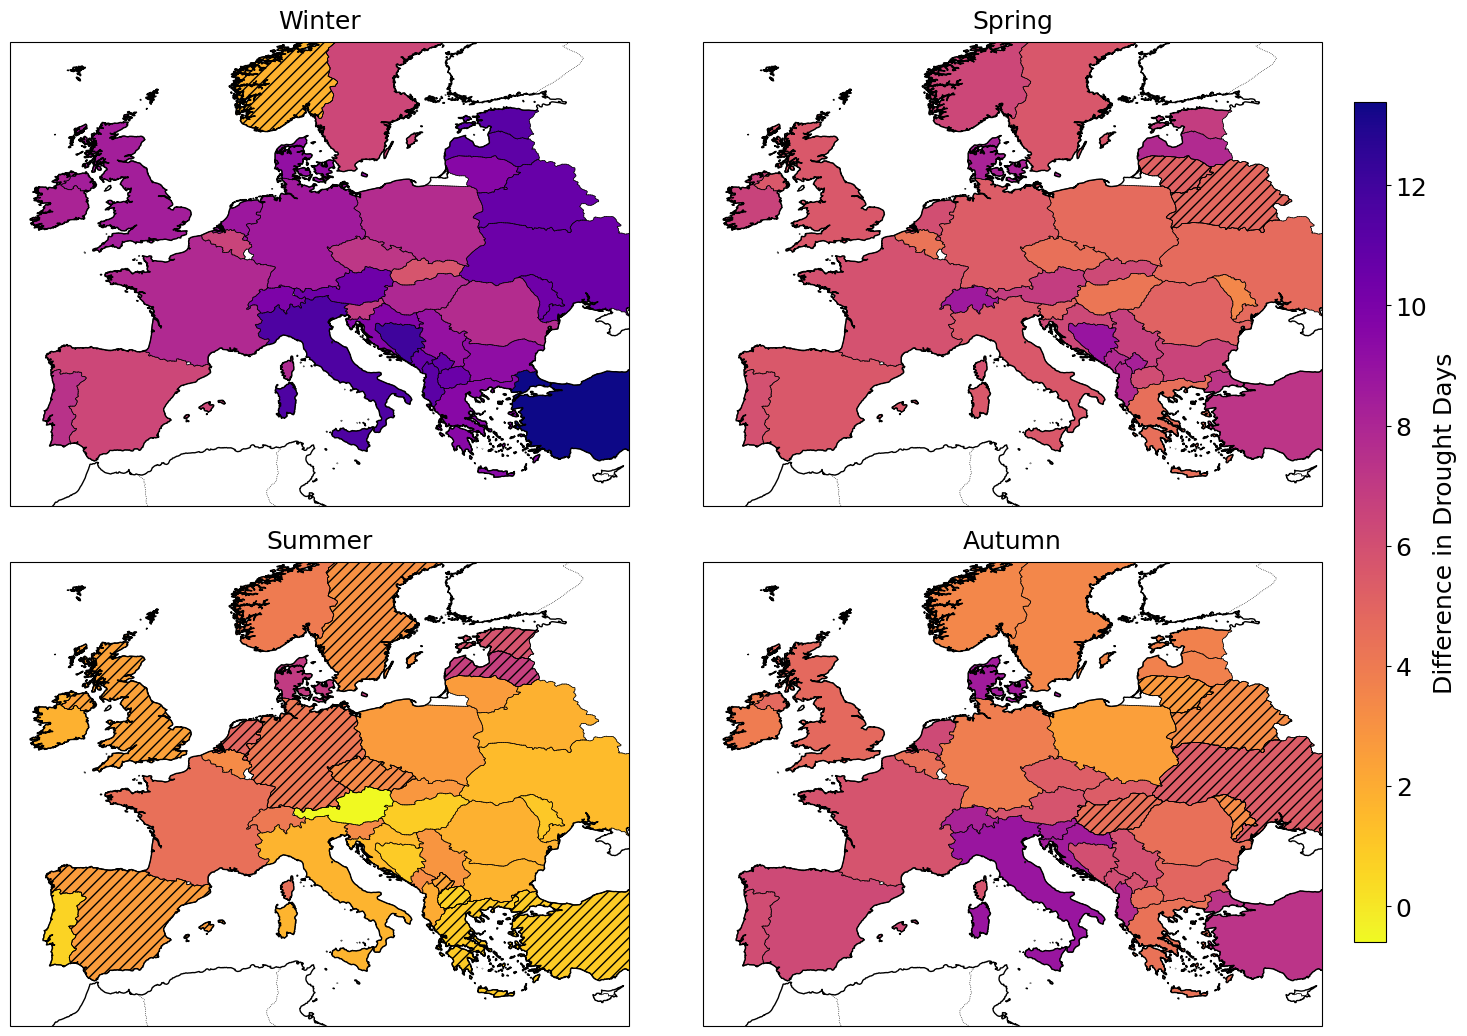

In [16]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches

# ─── 1) Read in the seasonal stats CSV ──────────────────────────────
power_dir = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power"
csv_path  = os.path.join(power_dir, "country_seasonal_era5_vs_boc_days.csv")
df        = pd.read_csv(csv_path)
# expects columns: model, country_ISO3, season, mean_era5_days, mean_boc_days, diff_days, significant

# ─── 2) For each country_ISO3×season:
#     a) median of diff_days
#     b) count of significant models
seasons = ["Winter","Spring","Summer","Autumn"]
med_diff = (
    df.groupby(["country_ISO3","season"])["diff_days"]
      .median()
      .reset_index(name="median_diff")
)
counts   = (
    df[df["significant"]]
      .groupby(["country_ISO3","season"])["model"]
      .nunique()
      .reset_index(name="n_models_significant")
)

# fill missing combos
EU27 = ['AUT','BEL','BGR','HRV','CYP','CZE','DNK','EST','FRA','DEU','GRC',
        'HUN','IRL','ITA','LVA','LTU','LUX','MLT','NLD','POL','PRT','ROU',
        'SVK','SVN','ESP','SWE']
extras = ['GBR','NOR','BIH','MNE','SRB','ALB','MKD','CHE','ISL','TUR','UKR','BLR','MDA','KOS']
all_iso3 = EU27 + extras

full = pd.MultiIndex.from_product([all_iso3, seasons],
                                  names=["country_ISO3","season"])
med  = med_diff.set_index(["country_ISO3","season"]).reindex(full).reset_index()
cnt  = counts.set_index(["country_ISO3","season"]).reindex(full, fill_value=0).reset_index()
summary = med.merge(cnt, on=["country_ISO3","season"])

# ─── 3) Load country geometries keyed by ISO3 ───────────────────────
ne50  = "https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip"
world = gpd.read_file(ne50).set_crs("EPSG:4326")
# fix Kosovo & Türkiye
world.loc[world.ADM0_A3 == "RKS",       "ADM0_A3"] = "KOS"
world.loc[world.NAME_LONG == "Türkiye", "ADM0_A3"] = "TUR"

eu = (
    world[world.ADM0_A3.isin(all_iso3)]
      [["ADM0_A3","geometry"]]
      .rename(columns={"ADM0_A3":"country_ISO3"})
)

gdf = eu.merge(summary, on="country_ISO3", how="left")

# Countries with zero agreement → mask their median_diff to NaN so they plot grey
gdf.loc[gdf["n_models_significant"] == 0, "median_diff"] = np.nan

# ─── 4) Set up diverging colormap clipped at 5–95% ──────────────────
vmin = gdf["median_diff"].min()
vmax = gdf["median_diff"].max()
cmap = plt.get_cmap("plasma_r")
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

# ─── 5) Draw 2×2 seasonal panel ────────────────────────────────────
fig, axes = plt.subplots(
    2, 2,
    figsize=(16,12),
    subplot_kw={"projection": ccrs.PlateCarree()},
    constrained_layout=False
)

for ax, season in zip(axes.flat, seasons):
    sub = gdf[gdf["season"] == season]
    sub.plot(
        column="median_diff",
        cmap=cmap, norm=norm,
        linewidth=0.5, edgecolor="black",
        ax=ax,
        missing_kwds={"color":"white"}
    )
    # hatch those with 1–4 models significant
    low = sub[(sub["n_models_significant"] > 0) & (sub["n_models_significant"] < 5)]
    if not low.empty:
        low.plot(
            facecolor="none", edgecolor="black",
            hatch="///", linewidth=0.5,
            ax=ax, zorder=3
        )
    ax.coastlines("10m", linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.5)
    ax.set_extent([-12,35,33,64], ccrs.PlateCarree())
    ax.set_aspect("auto")
    ax.set_title(season, fontsize=18, pad=10)

# ─── 6) Title and shared colorbar & legend ─────────────────────────
fig.subplots_adjust(left=0.03, right=0.85, top=0.90, bottom=0.08,
                    wspace=0.12, hspace=0.12)


# colorbar
cax = fig.add_axes([0.87, 0.15, 0.02, 0.7])
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label("Difference in Drought Days", fontsize=18)
cbar.ax.tick_params(labelsize=18)

plt.savefig("/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/figures/ERA5_seasonal_diff.pdf", bbox_inches='tight', dpi=300)
plt.show()
